<a href="https://colab.research.google.com/github/oektomo/KelasRLG2/blob/master/DQL_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install score
# https://gsurma.medium.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288

In [1]:
import random
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# from scores.score_logger import ScoreLogger

ENV_NAME = "CartPole-v1"

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

2022-04-13 18:53:11.216045: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/otm/notebook/jupyterenv/lib/python3.8/site-packages/cv2/../../lib64::/home/otm/.mujoco/mjpro150/bin
2022-04-13 18:53:11.216080: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/otm/notebook/jupyterenv/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/otm/notebook/jupyterenv/lib/python3.8/site-packages/tensorflow/

In [2]:
class DQNSolver:
  def __init__(self, observation_space, action_space):
    self.exploration_rate = EXPLORATION_MAX
    
    self.action_space = action_space
    self.memory = deque(maxlen=MEMORY_SIZE)

    self.model = Sequential()
    self.model.add(Dense(24, input_shape=(observation_space, ), activation="relu"))
    self.model.add(Dense(24, activation="relu"))
    self.model.add(Dense(self.action_space, activation="linear"))
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    self.model.compile(loss="mse", optimizer=Adam(learning_rate=LEARNING_RATE))
  
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  # choose if we want to explore or use the neural net
  def act(self, state):
    if np.random.rand() < self.exploration_rate:
      return random.randrange(self.action_space)
    q_values = self.model.predict(state)
    return np.argmax(q_values[0])

  # Replay Memory in Experience Replay
  def experience_replay(self):
    if len(self.memory) < BATCH_SIZE:
      return
    batch = random.sample(self.memory, BATCH_SIZE)
    for state, action, reward, state_next, terminal in batch:
      q_update = reward
      if not terminal:
        q_update = reward + GAMMA * np.amax(self.model.predict(state_next)[0])
      q_values = self.model.predict(state)
      q_values[0][action] = q_update
      self.model.fit(state, q_values, verbose=0)
    self.exploration_rate *= EXPLORATION_DECAY
    self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [3]:
def cartpole(max_run = 3):
    env = gym.make(ENV_NAME)
    #score_logger = ScoreLogger(ENV_NAME)
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
    run = 0
    score = []
    lcpos = [] # longest episode cart position
    lcvel = [] # longest episode cart velocity
    lpangl = [] # longest episode pole angle
    #max_run = 3
    while True:
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        cpos = []
        cvel = []
        pangl = []
        cpos.append(state[0,0])
        cvel.append(state[0,1])
        pangl.append(state[0,2])
        while True:
            step += 1
            #env.render()
            action = dqn_solver.act(state)
            state_next, reward, terminal, info = env.step(action)
            cpos.append(state_next[0])
            cvel.append(state_next[1])
            pangl.append(math.degrees(state_next[2]))
            reward = reward if not terminal else -reward
            state_next = np.reshape(state_next, [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            state = state_next
            if terminal:
                print ("Episode: "+str(run)+
                       ", exploration: "+str(round(dqn_solver.exploration_rate, 3))+
                       ", score: "+str(step)+
                       ", pos: "+str(round(state_next[0,0], 3))+
                       ", angle: "+str(round(math.degrees(state_next[0,2]), 2))+
                       " deg")
                score.append(step)
                #if cpos.size > lcpos.size:
                if len(cpos) > len(lcpos):
                    lcpos = cpos
                    lcvel = cvel
                    lpangl = pangl
                #plt.plot(pangl)
                #plt.plot(cvel)
                #score_logger.add_score(step, run)
                break
            dqn_solver.experience_replay()
        if run >= max_run:
            break
    plt.plot(score)
    return score, lcpos, lcvel, lpangl
    # todo: check the code for saving the longest episode cart speed, cart position, pole angle
    # refactor the code to make one list to record angle and score?

2022-04-13 18:53:24.889676: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/otm/notebook/jupyterenv/lib/python3.8/site-packages/cv2/../../lib64::/home/otm/.mujoco/mjpro150/bin
2022-04-13 18:53:24.889714: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 18:53:24.889745: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (orbit): /proc/driver/nvidia/version does not exist
2022-04-13 18:53:24.889992: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

Episode: 1, exploration: 1.0, score: 12, pos: 0.081, angle: -12.29 deg
Episode: 2, exploration: 0.975, score: 13, pos: -0.188, angle: 12.51 deg
Episode: 3, exploration: 0.843, score: 30, pos: -0.289, angle: 14.08 deg
Episode: 4, exploration: 0.751, score: 24, pos: -0.197, angle: 12.62 deg
Episode: 5, exploration: 0.687, score: 19, pos: -0.128, angle: 12.81 deg
Episode: 6, exploration: 0.653, score: 11, pos: -0.203, angle: 12.35 deg
Episode: 7, exploration: 0.612, score: 14, pos: -0.148, angle: 13.63 deg
Episode: 8, exploration: 0.568, score: 16, pos: -0.137, angle: 12.86 deg
Episode: 9, exploration: 0.532, score: 14, pos: -0.127, angle: 12.39 deg
Episode: 10, exploration: 0.506, score: 11, pos: -0.119, angle: 13.75 deg
Episode: 11, exploration: 0.46, score: 20, pos: -0.18, angle: 12.25 deg
Episode: 12, exploration: 0.437, score: 11, pos: -0.083, angle: 12.07 deg
Episode: 13, exploration: 0.386, score: 26, pos: -0.098, angle: 13.11 deg
Episode: 14, exploration: 0.353, score: 19, pos: -0

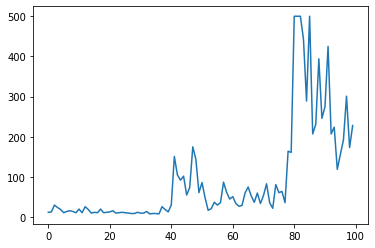

In [4]:
score, lcpos, lcvel, lpangl = cartpole(100)

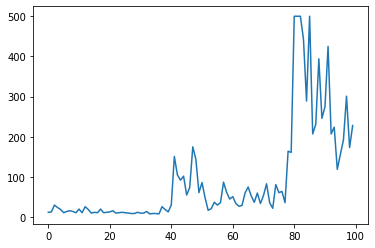

In [5]:
plt.plot(score)

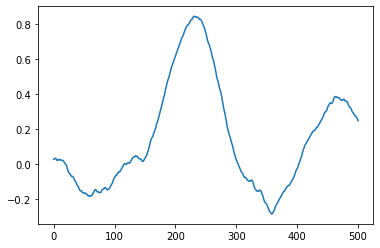

In [6]:
plt.plot(lcpos)

In [ ]:
env.observation_space.shape[0]

In [ ]:
env.action_space


    Observation: 
        Type: Box(4)

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8                 | 4.8                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    **Note:** While the ranges above denote the possible values for observation space of each element, 
    it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)


    Action:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right